In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import time
import torch

from datasets import load_metric
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from torch import cuda
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler,
    random_split,
    )
from tqdm import tqdm
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoTokenizer,
    BertForSequenceClassification,
    BertTokenizer,
    get_linear_schedule_with_warmup,
    T5ForSequenceClassification,
    T5Tokenizer,
    )
from razdel import tokenize

выбираем устройство для проведения обучения. 

In [2]:
device = 'cuda' if cuda.is_available() else 'cpu'

подгружаем наши датасеты

In [3]:
train_df = pd.read_csv("./data/in_domain_train.csv",index_col=0)
test_df = pd.read_csv("./data/in_domain_dev.csv",index_col=0)

немножко информации о них посмотрим

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7869 entries, 0 to 7868
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentence         7869 non-null   object
 1   acceptable       7869 non-null   int64 
 2   error_type       7869 non-null   object
 3   detailed_source  7869 non-null   object
dtypes: int64(1), object(3)
memory usage: 307.4+ KB


In [5]:
train_df.head()

,sentence,acceptable,error_type,detailed_source
id,,,,
0,"Вдруг решетка беззвучно поехала в сторону, и н...",1,0,Paducheva2004
1,Этим летом не никуда ездили.,0,Syntax,Rusgram
2,Только Иван выразил какую бы то ни было готовн...,1,0,Paducheva2013
3,"Теперь ты видишь собственными глазами, как тут...",1,0,Paducheva2010
4,На поверку вся теория оказалась полной чепухой.,1,0,Paducheva2010


In [6]:
train_df.sample()

,sentence,acceptable,error_type,detailed_source
id,,,,
7713,Ты сейчас же взял и вылил воду!,0,Semantics,Rusgram


выделим необходимые для нас колонки в отдельные переменные

In [7]:
train_sentences = train_df.sentence.values
train_labels = train_df.acceptable.values
test_sentences = test_df.sentence.values
test_labels = test_df.acceptable.values

я обучал на 2060, перепробовал large модели - к сожалению они не лезут. И чтобы побыстрей менять модельки - я вынес имя в отдельную переменную

In [8]:
model_name="ai-forever/ruBert-base"

подгрузим токенизатор для текста из предобученной берт модели

In [9]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

Loading BERT tokenizer...


посмотрим на то как он работает

In [10]:
# Выводим исходное предложение.
print('Исходное: ', train_sentences[0])

# Выводим предложение, разделенное на токены.
print('Токенизированное: ', tokenizer.tokenize(train_sentences[0]))

# Выводим предложение, сопоставленное идентификаторам токенов.
print('Идентификаторы токенов: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sentences[0])))

Исходное:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Токенизированное:  ['вдруг', 'решетка', 'беззвучно', 'поехала', 'в', 'сторону', ',', 'и', 'на', 'балконе', 'возникла', 'таинственная', 'фигура', ',', 'прячу', '##щаяся', 'от', 'лунного', 'света', ',', 'и', 'погрозил', '##а', 'ива', '##ну', 'пальцем', '.']
Идентификаторы токенов:  [3014, 83321, 41548, 32350, 113, 2931, 121, 107, 660, 50354, 13779, 99183, 15226, 121, 94376, 19913, 700, 55918, 6412, 121, 107, 95640, 377, 104691, 717, 11420, 126]


найдем максимальную длину текста

In [11]:
max_len = 0

for sent in train_sentences:

    # токенизируем текст, не забывая добавлять специальный токен начала и конца([CLS] и [SEP])
    train_input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Сравниваем длину последовательности и если она длиннее - обновляем max_len
    max_len = max(max_len, len(train_input_ids))

print('Максимальная длина текста: ', max_len)


Максимальная длина текста:  45


напишем функцию токенизации текста

In [8]:
def encode(sentences,tokenizer):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        # `encode_plus` выполнит следующие шаги:
        #   (1) Токенизирует предложение.
        #   (2) Добавит токен `[CLS]` в начало.
        #   (3) Добавит токен `[SEP]` в конец.
        #   (4) Сопоставит токены их идентификаторам.
        #   (5) Дополнит или обрежет предложение до `max_length`.
        #   (6) Создаст маски внимания для токенов [PAD].

        # Используем `encode_plus` для кодирования предложения.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Предложение для кодирования.
                            add_special_tokens = True, # Добавить '[CLS]' и '[SEP]'.
                            max_length = 64,           # Дополнить и обрезать все предложения.
                            pad_to_max_length = True,  # Дополнить до максимальной длины и обрезать.
                            return_attention_mask = True,   # Создать маски внимания.
                            return_tensors = 'pt',     # Вернуть тензоры PyTorch.
                    )

        # Добавляем закодированное предложение в список.
        input_ids.append(encoded_dict['input_ids'])

        # А также его маску внимания (просто отличает заполнение от незаполненного).
        attention_masks.append(encoded_dict['attention_mask'])

    # Возвращаем списки тензоров для input_ids и attention_masks.
    return input_ids, attention_masks

перекодируем и приготовим наши списки к дальнейшему превращению в тензорные датасеты

In [13]:
# Токенизируем все предложения и сопоставляем токены их идентификаторам слов.
train_input_ids, train_attention_masks = encode(train_sentences,tokenizer)
test_input_ids, test_attention_masks = encode(test_sentences,tokenizer)

# Преобразуем списки в тензоры.
train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)
train_labels = torch.tensor(train_labels)

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

# Выводим первое предложение как список идентификаторов слов.
print('Исходное предложение: ', train_sentences[0])
print('Идентификаторы слов:', train_input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/vlamykin/git/NLP_OTUS_2023/env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Исходное предложение:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Идентификаторы слов: tensor([   101,   3014,  83321,  41548,  32350,    113,   2931,    121,    107,
           660,  50354,  13779,  99183,  15226,    121,  94376,  19913,    700,
         55918,   6412,    121,    107,  95640,    377, 104691,    717,  11420,
           126,    102,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])


сделаем тренировочный, валидационный тензоры и приготовим тензор на котором будем тестировать

In [14]:
# Создаем TensorDataset из тензоров train_input_ids, train_attention_masks и train_labels.
dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

# Создаем разделение данных на обучающую и валидационную выборки в пропорции 90-10.
# Вычисляем количество образцов в каждом наборе.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Делим набор данных, случайным образом выбирая образцы.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Выводим информацию о количестве образцов в обучающей и валидационной выборках.
print('{:>5,} образцов для обучения'.format(train_size))
print('{:>5,} образцов для валидации'.format(val_size))

# Создаем TensorDataset для тестовых данных.
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)


7,082 образцов для обучения
  787 образцов для валидации


приготовим даталоадеры для удобства обучения

In [15]:
# DataLoader должен знать размер нашего батча для обучения, поэтому мы указываем его здесь.
# При fine-tuning BERT на конкретной задаче авторы рекомендуют размер батча 16 или 32.
batch_size = 32

# Создаем DataLoaders для наших обучающих и валидационных наборов данных.
# Образцы для обучения будем брать в случайном порядке.
train_dataloader = DataLoader(
            train_dataset,  # Обучающие образцы.
            sampler = RandomSampler(train_dataset), # Выбираем батчи случайным образом.
            batch_size = batch_size # Обучение с этим размером батча.
        )

# Для валидации порядок не имеет значения, поэтому мы просто читаем их последовательно.
validation_dataloader = DataLoader(
            val_dataset, # Валидационные образцы.
            sampler = SequentialSampler(val_dataset), # Извлекаем батчи последовательно.
            batch_size = batch_size # Оценка с этим размером батча.
        )

# DataLoader для тестовых данных.
test_dataloader = DataLoader(
            test_dataset, # Тестовые образцы.
            sampler = SequentialSampler(test_dataset), # Извлекаем батчи последовательно.
            batch_size = batch_size # Оценка с этим размером батча.
        )

подгрузим модель и перенесем ее на графические ядра

In [16]:
# Загружаем BertForSequenceClassification, предобученную модель BERT с одним
# линейным слоем классификации сверху.
model = BertForSequenceClassification.from_pretrained(
    model_name,       # Используем 12-слойную модель BERT с uncased словарем.
    num_labels=4,      # Количество выходных меток -- 2 для бинарной классификации.
                       # Можно увеличить для многоклассовых задач.
    output_attentions=False,    # Возвращает ли модель веса внимания.
    output_hidden_states=False, # Возвращает ли модель все скрытые состояния.
)

# Указываем PyTorch использовать GPU для выполнения этой модели.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

посмотрим на параметры берта 

In [17]:
# Получаем все параметры модели в виде списка кортежей.
params = list(model.named_parameters())

print('У модели BERT {:} различных именованных параметров.\n'.format(len(params)))

print('==== Слой вложения ====\n')

# Выводим размерности параметров для слоя вложения.
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Первый трансформер ====\n')

# Выводим размерности параметров для первого трансформера.
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Выходной слой ====\n')

# Выводим размерности параметров для выходного слоя.
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


У модели BERT 201 различных именованных параметров.

==== Слой вложения ====

bert.embeddings.word_embeddings.weight                  (120138, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== Первый трансформер ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

зададим оптимизатор

In [18]:
# Примечание: AdamW - это класс из библиотеки huggingface (в отличие от pytorch)
# Вероятно, 'W' означает 'Weight Decay fix' (исправление весового распада, что есть не очень понятно по звучанию).

# Инициализируем оптимизатор AdamW.
optimizer = AdamW(model.parameters(),
                  lr=2e-5,   # Скорость обучения - по умолчанию 5e-5, в нашем случае 2e-5.
                  eps=1e-8   # Epsilon для Adam - по умолчанию 1e-8.
                )



/home/vlamykin/git/NLP_OTUS_2023/env/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


зададим параметры обучения

In [19]:
# Количество эпох обучения. Авторы BERT рекомендуют от 2 до 4 эпох.
# Мы выбрали 4, но позже увидим, что это может привести к переобучению.

epochs = 4

# Общее количество шагов обучения - [количество батчей] x [количество эпох].
# (Обратите внимание, что это не то же самое, что количество обучающих образцов).
total_steps = len(train_dataloader) * epochs

# Создаем планировщик скорости обучения.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, # Значение по умолчанию в run_glue.py.
                                            num_training_steps=total_steps)


In [20]:
# Функция для вычисления точности наших предсказаний по сравнению с метками.
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
def format_time(elapsed):
    '''
    Принимает время в секундах и возвращает строку в формате чч:мм:сс.
    '''
    # Округляем до ближайшей секунды.
    elapsed_rounded = int(round(elapsed))

    # Форматируем как чч:мм:сс
    return str(datetime.timedelta(seconds=elapsed_rounded))


обучим модельку

In [22]:
# Этот код обучения основан на скрипте `run_glue.py` здесь:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Устанавливаем значение seed для воспроизводимости.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Будем хранить несколько показателей, таких как обучающая и валидационная ошибка,
# точность валидации и затраченное время.
training_stats = []

# Измерим общее время обучения для всего запуска.
total_t0 = time.time()

# Для каждой эпохи...
for epoch_i in range(0, epochs):

    # ========================================
    #               Обучение
    # ========================================

    # Выполняем один полный проход по обучающему набору.

    print("")
    print('======== Эпоха {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Обучение...')

    # Измеряем время обучения эпохи.
    t0 = time.time()

    # Сбрасываем общую ошибку для этой эпохи.
    total_train_loss = 0

    # Переводим модель в режим обучения. Не путайтесь -- вызов
    # `train` просто изменяет *режим*, он не выполняет *обучение*.
    # `dropout` и `batchnorm` ведут себя по-разному во время обучения
    # по сравнению с тестированием (источник: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # Для каждого батча обучающих данных...
    for step, batch in enumerate(train_dataloader):

        # Обновление каждые 40 батчей.
        if step % 40 == 0 and not step == 0:
            # Вычисляем прошедшее время в минутах.
            elapsed = format_time(time.time() - t0)

            # Сообщаем о ходе выполнения.
            print('  Батч {:>5,}  из  {:>5,}.    Затраченное время: {:}.'.format(step, len(train_dataloader), elapsed))

        # Распаковываем этот батч из нашего загрузчика данных.
        #
        # При распаковке батча мы также копируем каждый тензор на GPU, используя
        # метод `to`.
        #
        # `batch` содержит три тензора PyTorch:
        #   [0]: идентификаторы входа
        #   [1]: маски внимания
        #   [2]: метки
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Всегда очищаем ранее вычисленные градиенты перед
        # выполнением обратного прохода. PyTorch не делает это автоматически,
        # потому что накопление градиентов "удобно при обучении RNN".
        # (источник: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Выполняем прямой проход (оцениваем модель на этом обучающем батче).
        # Документация по этой функции `model` находится здесь:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # Она возвращает разное количество параметров в зависимости от того, какие аргументы
        # предоставлены и какие флаги установлены. Для нашего использования здесь она возвращает
        # потери (поскольку мы предоставили метки) и "логиты" - выходные
        # значения модели до применения активационной функции, такой как softmax.
        res = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Накапливаем обучающую потерю по всем батчам, чтобы мы могли
        # вычислить среднюю потерю в конце. `loss` - это тензор, содержащий одно значение;
        # функция `.item()` просто возвращает значение Python из тензора.
        total_train_loss += loss.item()

        # Выполняем обратный проход для вычисления градиентов.
        loss.backward()

        # Ограничиваем норму градиентов до 1.0.
        # Это помогает предотвратить проблему "взрывающихся градиентов".
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Обновляем параметры и делаем шаг с использованием вычисленного градиента.
        # Оптимизатор определяет "правило обновления" - как параметры
        # изменяются на основе их градиентов, скорости обучения и т. д.
        optimizer.step()

        # Обновляем скорость обучения.
        scheduler.step()

    # Вычисляем среднюю потерю по всем батчам.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Измеряем, сколько времени заняла эта эпоха.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Средняя обучающая потеря: {0:.2f}".format(avg_train_loss))
    print("  Эпоха обучения заняла: {:}".format(training_time))

    # ========================================
    #               Валидация
    # ========================================
    # После завершения каждой обучающей эпохи измеряем нашу производительность
    # на валидационном наборе данных.

    print("")
    print("Запуск валидации...")

    t0 = time.time()

    # Переводим модель в режим оценки - слои dropout ведут себя по-другому
    # во время оценки.
    model.eval()

    # Переменные для отслеживания
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Оцениваем данные для одной эпохи.
    for batch in validation_dataloader:

        # Распаковываем этот батч из нашего загрузчика данных.
        #
        # При распаковке батча мы также копируем каждый тензор на GPU с использованием
        # метода `to`.
        #
        # `batch` содержит три тензора PyTorch:
        #   [0]: идентификаторы входа
        #   [1]: маски внимания
        #   [2]: метки
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Говорим PyTorch не беспокоиться о построении вычислительного графа
        # во время прямого прохода, поскольку это нужно только для обратного
        # распространения (обучение).
        with torch.no_grad():

            # Прямой проход, вычисляем прогнозы логитов.
            # token_type_ids - это то же самое, что и "segment ids", которые
            # различают предложения 1 и 2 в 2-предложных задачах.
            # Документация по этой функции `model` находится здесь:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Получаем "логиты", выводимые моделью перед применением активационной функции, такой как softmax.
            res = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Накапливаем потери валидации.
        total_eval_loss += loss.item()

        # Перемещаем логиты и метки на CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Вычисляем точность для этого батча тестовых предложений и
        # накапливаем ее по всем батчам.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Сообщаем конечную точность для этого прогона валидации.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Точность: {0:.2f}".format(avg_val_accuracy))

    # Вычисляем средние потери по всем батчам.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Измеряем, сколько времени занял этот прогон валидации.
    validation_time = format_time(time.time() - t0)

    print("  Потери валидации: {0:.2f}".format(avg_val_loss))
    print("  Валидация заняла: {:}".format(validation_time))

    # Записываем все статистические данные из этой эпохи.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Обучающая потеря': avg_train_loss,
            'Потери на валидации': avg_val_loss,
            'Точность на валидации': avg_val_accuracy,
            'Время обучения': training_time,
            'Время валидации': validation_time
        }
    )

print("")
print("Обучение завершено!")

print("Всего обучение заняло {:} (ч:м:с)".format(format_time(time.time()-total_t0)))



======== Эпоха 1 / 4 ========
Обучение...
  Батч    40  из    222.    Затраченное время: 0:00:14.
  Батч    80  из    222.    Затраченное время: 0:00:28.
  Батч   120  из    222.    Затраченное время: 0:00:41.
  Батч   160  из    222.    Затраченное время: 0:00:55.
  Батч   200  из    222.    Затраченное время: 0:01:09.

  Средняя обучающая потеря: 0.55
  Эпоха обучения заняла: 0:01:16

Запуск валидации...
  Точность: 0.80
  Потери валидации: 0.47
  Валидация заняла: 0:00:03

======== Эпоха 2 / 4 ========
Обучение...
  Батч    40  из    222.    Затраченное время: 0:00:14.
  Батч    80  из    222.    Затраченное время: 0:00:28.
  Батч   120  из    222.    Затраченное время: 0:00:43.
  Батч   160  из    222.    Затраченное время: 0:00:59.
  Батч   200  из    222.    Затраченное время: 0:01:14.

  Средняя обучающая потеря: 0.35
  Эпоха обучения заняла: 0:01:22

Запуск валидации...
  Точность: 0.80
  Потери валидации: 0.47
  Валидация заняла: 0:00:03

======== Эпоха 3 / 4 ========
Обучени

посмотрим на качество модели и время её обучения

In [23]:
# Отображаем числа с двумя десятичными знаками.
#pd.set_option('precision', 2)

# Создаем DataFrame из наших статистических данных обучения.
df_stats = pd.DataFrame(data=training_stats)

# Используем 'epoch' в качестве индекса строк.
df_stats = df_stats.set_index('epoch')

# Хак для принудительного переноса заголовков столбцов.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Отображаем таблицу.
df_stats


,Обучающая потеря,Потери на валидации,Точность на валидации,Время обучения,Время валидации
epoch,,,,,
1,0.545811,0.470885,0.800329,0:01:16,0:00:03
2,0.352870,0.468839,0.804079,0:01:22,0:00:03
3,0.214832,0.595731,0.802829,0:01:27,0:00:03
4,0.128987,0.672567,0.808684,0:01:29,0:00:03


отрисуем лосс для обучающей и валидационной выборки на эпохах

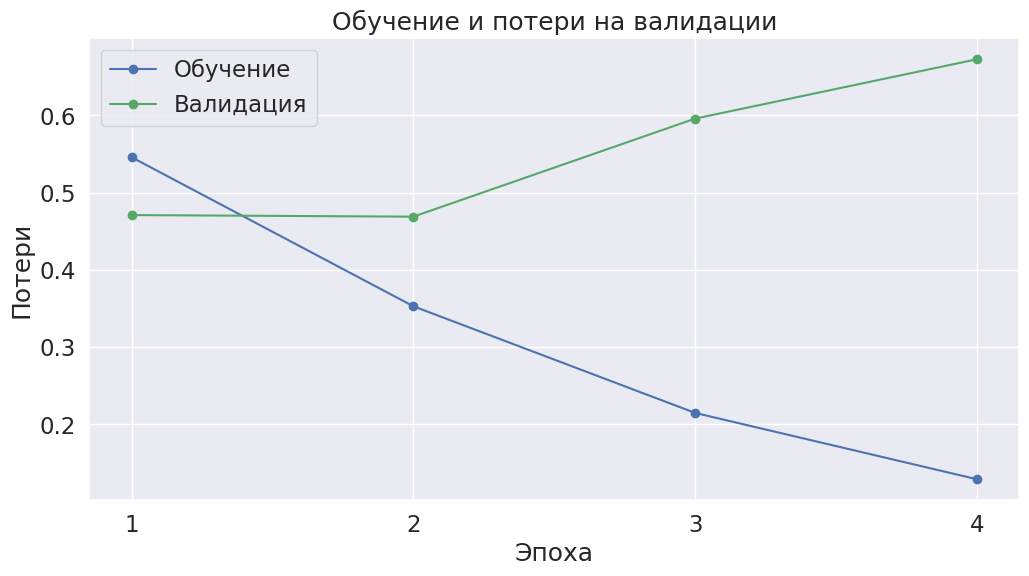

In [24]:
# Используем стиль для графиков от seaborn.
sns.set(style='darkgrid')

# Увеличиваем размер графика и размер шрифта.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Рисуем кривую обучения.
plt.plot(df_stats['Обучающая потеря'], 'b-o', label="Обучение")
plt.plot(df_stats['Потери на валидации'], 'g-o', label="Валидация")

# Даем название графику.
plt.title("Обучение и потери на валидации")
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()


протеструем модель на тестовом наборе данных, который подгрузили и разбили так же в начале из отдельного файла

In [25]:
# Прогнозирование на тестовом наборе данных

print('Прогноз меток для {:,} тестовых предложений...'.format(len(test_input_ids)))

# Переводим модель в режим оценки
model.eval()

# Переменные для отслеживания
predictions , true_labels = [], []

# Прогнозируем
for batch in test_dataloader:
  # Добавляем батч на GPU
  batch = tuple(t.to(device) for t in batch)

  # Распаковываем входы из нашего загрузчика данных
  b_input_ids, b_input_mask, b_labels = batch

  # Скажем модели не вычислять или хранить градиенты, экономя память и
  # ускоряя прогноз
  with torch.no_grad():
      # Прямой проход, расчет прогнозов логитов
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Перемещаем логиты и метки на CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Сохраняем прогнозы и истинные метки
  predictions.append(logits)
  true_labels.append(label_ids)

print('    ГОТОВО.')

Прогноз меток для 983 тестовых предложений...
    ГОТОВО.


выведем отношение хороших текстов к общему количеству

In [26]:
print('Положительные примеры: %d из %d (%.2f%%)' % (test_df.acceptable.sum(), len(test_df.acceptable), (test_df.acceptable.sum() / len(test_df.acceptable) * 100.0)))

Положительные примеры: 733 из 983 (74.57%)


посчитаем коэффициент корреляции Мэтьюса для каждого батча

In [27]:
matthews_set = []

# Оцениваем каждый тестовый батч с использованием коэффициента корреляции Мэтьюса
print('Расчет коэффициента корреляции Мэтьюса для каждого батча...')

# Для каждого входного батча...
for i in range(len(true_labels)):

  # Прогнозы для этого батча - это ndarray из 2 столбцов (один столбец для "0"
  # и один столбец для "1"). Выбираем метку с наивысшим значением и превращаем это
  # в список из 0 и 1.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Рассчитываем и сохраняем коэффициент для этого батча.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)


Расчет коэффициента корреляции Мэтьюса для каждого батча...


выведем общий MCC для теста

In [28]:
# Объединяем результаты по всем батчам.
flat_predictions = np.concatenate(predictions, axis=0)

# Для каждого образца выбираем метку (0 или 1) с более высоким значением.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Объединяем правильные метки для каждого батча в единый список.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Рассчитываем коэффициент корреляции Мэтьюса (MCC)
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Общий MCC: %.3f' % mcc)


Общий MCC: 0.380


почистим наш гпу... памяти мало... Очень странно но пока не перегонял на цпу - очистка не шла. и даже после этого она была не полноценной, но лучше чем ничего.

In [29]:
model_name = "ai-forever/rugpt3small_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [30]:
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50264, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50264, bias=False)
)

In [31]:
def calc_loss(phrase: str,
                        tokenizer,
                        model):

    phrase = tokenizer.encode(phrase)
    # Если длина фразы 1 токен, то дальше ошибка вылезет :(
    if len(phrase) == 1:
         phrase.append(tokenizer.eos_token_id)
    phrase = torch.tensor(phrase, dtype=torch.long, device=device)
    phrase = phrase.unsqueeze(0)  # .repeat(num_samples, 1)
    with torch.no_grad():
        loss = model(phrase, labels=phrase)

    loss[0].item()


    return loss[0].item()

def get_loss_num(text):
    loss = calc_loss(phrase=text, model=model, tokenizer=tokenizer)
    return loss

сделаем цикл, который проверит few-shot и цикл zero-shot

In [32]:
for i in [0, 1, 2, 4]:
    random_samples = train_df.sample(n=i+1, random_state=42)

    few_shots = ""
    for index in range(i+1):
        answer = "Да" if random_samples.iloc[index]["acceptable"] == 1 else "Нет"
        few_shots += f'     Предложение далее корректное? {random_samples.iloc[index]["sentence"]}  Ответ: {answer}.\n'

    loss = get_loss_num(few_shots)
    print(f'Количество few-shot: {i}\nFew-shot текст:\n{few_shots}Потери: {loss}\n')

Количество few-shot: 0
Few-shot текст:
     Предложение далее корректное? В Белоруссии либеральные газеты не остались.  Ответ: Нет.
Потери: 6.528524875640869

Количество few-shot: 1
Few-shot текст:
     Предложение далее корректное? В Белоруссии либеральные газеты не остались.  Ответ: Нет.
     Предложение далее корректное? Иван хочет, чтобы Петр пригласил его к себе.  Ответ: Да.
Потери: 4.452184677124023

Количество few-shot: 2
Few-shot текст:
     Предложение далее корректное? В Белоруссии либеральные газеты не остались.  Ответ: Нет.
     Предложение далее корректное? Иван хочет, чтобы Петр пригласил его к себе.  Ответ: Да.
     Предложение далее корректное? Дубровский назначил Кистеневскую рощу местом свиданья.  Ответ: Да.
Потери: 3.756847858428955

Количество few-shot: 4
Few-shot текст:
     Предложение далее корректное? В Белоруссии либеральные газеты не остались.  Ответ: Нет.
     Предложение далее корректное? Иван хочет, чтобы Петр пригласил его к себе.  Ответ: Да.
     Предложе

In [33]:
random_sample=train_df.sample(n=1, random_state=42)
sentence=random_sample.iloc[0]["sentence"]
label="Да" if random_sample.iloc[0]["acceptable"] == 1 else "Нет"
def zero_shot(start,end):
    text=start+sentence+end
    loss=get_loss_num(text)
    print(f"Текст: {sentence}\nОн правильный:{label}\nТекст с затравками: {text}\nПотери: {loss}")
    

In [34]:
def generate_random_positive_negative_combinations(num_variations=100):
    positive_prefixes = [
        "Это правильно. ",
        "100% ",
        "Блестяще. ",
        "В десятку. ",
        "))) "
    ]

    negative_prefixes = [
        "Не правильно. ",
        "Косяк. ",
        "0% ",
        "(((. ",
        "Фейл. "
    ]

    positive_suffixes = [
        " Это великолепно.",
        " )))",
        " В точку.",
        " Замечательно!",
        " В 100-чку!"
    ]

    negative_suffixes = [
        " Это пичалька.",
        " Оставляет желать лучшего.",
        " (((",
        " Эт дно.",
        " Фигня."
    ]

    combinations = []

    for _ in range(num_variations):
        if random.choice([True, False]):  # Randomly choose positive or negative
            prefix = random.choice(positive_prefixes)
            suffix = random.choice(positive_suffixes)
        else:
            prefix = random.choice(negative_prefixes)
            suffix = random.choice(negative_suffixes)

        combinations.append((prefix, suffix))

    return combinations

# приготовим пачку комбинаций
combinations = generate_random_positive_negative_combinations(100)

# бомбанем по ним зирошотом 
for i, (prefix, suffix) in enumerate(combinations[:10], 1):
    zero_shot(prefix,suffix)


Текст: В Белоруссии либеральные газеты не остались.
Он правильный:Нет
Текст с затравками: Это правильно. В Белоруссии либеральные газеты не остались. В точку.
Потери: 5.480813980102539
Текст: В Белоруссии либеральные газеты не остались.
Он правильный:Нет
Текст с затравками: 100% В Белоруссии либеральные газеты не остались. )))
Потери: 6.629759311676025
Текст: В Белоруссии либеральные газеты не остались.
Он правильный:Нет
Текст с затравками: ))) В Белоруссии либеральные газеты не остались. Это великолепно.
Потери: 6.023663520812988
Текст: В Белоруссии либеральные газеты не остались.
Он правильный:Нет
Текст с затравками: Не правильно. В Белоруссии либеральные газеты не остались. Это пичалька.
Потери: 4.9911346435546875
Текст: В Белоруссии либеральные газеты не остались.
Он правильный:Нет
Текст с затравками: 100% В Белоруссии либеральные газеты не остались. )))
Потери: 6.629759311676025
Текст: В Белоруссии либеральные газеты не остались.
Он правильный:Нет
Текст с затравками: ))) В Белорус

поизучал я t5 питоновский файл. Нет никаких объяснений, гора параметров и решил просто тупо попробовать обучить модельку. К тому же мне очень не понравилось что была выбрана T5ForConditionalGeneration а не T5ForSequenceClassification. Понятно, что это text-to-text model, но!!! не зря же люди голову для классификации придумывали.

In [9]:
model_name = "ai-forever/ruT5-base"
model = T5ForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = T5Tokenizer.from_pretrained(model_name)
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruT5-base and are newly initialized: ['classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight', 'classification_head.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/vlamykin/git/NLP_OTUS_2023/env/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
# Токенизируем все предложения и сопоставляем токены их идентификаторам слов.
train_input_ids, train_attention_masks = encode(train_sentences,tokenizer)
test_input_ids, test_attention_masks = encode(test_sentences,tokenizer)

# Преобразуем списки в тензоры.
train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)
train_labels = torch.tensor(train_labels)

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

# Выводим первое предложение как список идентификаторов слов.
print('Исходное предложение: ', train_sentences[0])
print('Идентификаторы слов:', train_input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/vlamykin/git/NLP_OTUS_2023/env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Исходное предложение:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Идентификаторы слов: tensor([ 6057, 31163, 25014,  7590,     7,     6,   619,     3,     5,     9,
         6730,    13, 10526,   565,   305,  8092,  8504,     3, 25694,  1852,
           57,    26,  3933,    99,  2164,     3,     5,    17, 21931,   536,
         1759,    18,  5066,     4,     2,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [11]:
# Создаем TensorDataset из тензоров train_input_ids, train_attention_masks и train_labels.
dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

# Создаем разделение данных на обучающую и валидационную выборки в пропорции 90-10.
# Вычисляем количество образцов в каждом наборе.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Делим набор данных, случайным образом выбирая образцы.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Выводим информацию о количестве образцов в обучающей и валидационной выборках.
print('{:>5,} образцов для обучения'.format(train_size))
print('{:>5,} образцов для валидации'.format(val_size))

# Создаем TensorDataset для тестовых данных.
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

7,082 образцов для обучения
  787 образцов для валидации


In [12]:
# DataLoader должен знать размер нашего батча для обучения, поэтому мы указываем его здесь.
batch_size = 16

# Создаем DataLoaders для наших обучающих и валидационных наборов данных.
# Образцы для обучения будем брать в случайном порядке.
train_dataloader = DataLoader(
            train_dataset,  # Обучающие образцы.
            sampler = RandomSampler(train_dataset), # Выбираем батчи случайным образом.
            batch_size = batch_size # Обучение с этим размером батча.
        )

# Для валидации порядок не имеет значения, поэтому мы просто читаем их последовательно.
validation_dataloader = DataLoader(
            val_dataset, # Валидационные образцы.
            sampler = SequentialSampler(val_dataset), # Извлекаем батчи последовательно.
            batch_size = batch_size # Оценка с этим размером батча.
        )

# DataLoader для тестовых данных.
test_dataloader = DataLoader(
            test_dataset, # Тестовые образцы.
            sampler = SequentialSampler(test_dataset), # Извлекаем батчи последовательно.
            batch_size = batch_size # Оценка с этим размером батча.
        )

In [13]:
epochs = 20
for epoch in range(epochs):
    # Обучающий цикл
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f"Эпоха {epoch+1} (Обучение)"):
        optimizer.zero_grad()
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        outputs = model(b_input_ids, labels=b_labels, attention_mask=b_input_mask)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_dataloader)
    print(f"Эпоха {epoch+1}, Средние потери при обучении: {average_loss}")

    # Валидационный цикл
    model.eval()
    val_total_loss = 0

    with torch.no_grad():
        for val_batch in tqdm(validation_dataloader, desc=f"Эпоха {epoch+1} (Валидация)"):
            b_input_ids = val_batch[0].to(device)
            b_input_mask = val_batch[1].to(device)
            b_labels = val_batch[2].to(device)

            val_outputs = model(b_input_ids, labels=b_labels, attention_mask=b_input_mask)
            val_loss = val_outputs.loss
            val_total_loss += val_loss.item()

    val_average_loss = val_total_loss / len(validation_dataloader)
    print(f"Эпоха {epoch+1}, Средние потери при валидации: {val_average_loss}")

# Тестовый цикл и вычисление MCC (Коэффициент корреляции Мэтьюса)
model.eval()
all_test_labels = []
all_predictions = []

with torch.no_grad():
    for test_batch in tqdm(test_dataloader, desc="Тестирование"):
        b_input_ids = test_batch[0].to(device)
        b_input_mask = test_batch[1].to(device)
        b_labels = test_batch[2].to(device)

        test_outputs = model(b_input_ids, labels=b_labels, attention_mask=b_input_mask)
        predictions = torch.argmax(test_outputs.logits, dim=1).cpu().numpy()

        all_test_labels.extend(b_labels.cpu().numpy())
        all_predictions.extend(predictions)

mcc = matthews_corrcoef(all_test_labels, all_predictions)
print(f"Коэффициент корреляции Мэтьюса на тестовом наборе: {mcc}")


Эпоха 1 (Обучение): 100%|██████████| 443/443 [03:13<00:00,  2.29it/s]


Эпоха 1, Средние потери при обучении: 0.611666705989138


Эпоха 1 (Валидация): 100%|██████████| 50/50 [00:06<00:00,  7.17it/s]


Эпоха 1, Средние потери при валидации: 0.5153628116846085


Эпоха 2 (Обучение): 100%|██████████| 443/443 [03:35<00:00,  2.06it/s]


Эпоха 2, Средние потери при обучении: 0.5866436129498966


Эпоха 2 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.89it/s]


Эпоха 2, Средние потери при валидации: 0.5140694439411163


Эпоха 3 (Обучение): 100%|██████████| 443/443 [03:41<00:00,  2.00it/s]


Эпоха 3, Средние потери при обучении: 0.5770175400827054


Эпоха 3 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


Эпоха 3, Средние потери при валидации: 0.523694808781147


Эпоха 4 (Обучение): 100%|██████████| 443/443 [03:47<00:00,  1.94it/s]


Эпоха 4, Средние потери при обучении: 0.5739507654988739


Эпоха 4 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.49it/s]


Эпоха 4, Средние потери при валидации: 0.5274526831507683


Эпоха 5 (Обучение): 100%|██████████| 443/443 [03:53<00:00,  1.90it/s]


Эпоха 5, Средние потери при обучении: 0.5706363726012056


Эпоха 5 (Валидация): 100%|██████████| 50/50 [00:09<00:00,  5.36it/s]


Эпоха 5, Средние потери при валидации: 0.5276537251472473


Эпоха 6 (Обучение): 100%|██████████| 443/443 [03:47<00:00,  1.94it/s]


Эпоха 6, Средние потери при обучении: 0.5670490543406381


Эпоха 6 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.41it/s]


Эпоха 6, Средние потери при валидации: 0.5081007480621338


Эпоха 7 (Обучение): 100%|██████████| 443/443 [03:50<00:00,  1.93it/s]


Эпоха 7, Средние потери при обучении: 0.5657402382276397


Эпоха 7 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.32it/s]


Эпоха 7, Средние потери при валидации: 0.5221782553195954


Эпоха 8 (Обучение): 100%|██████████| 443/443 [03:50<00:00,  1.92it/s]


Эпоха 8, Средние потери при обучении: 0.5556388683028469


Эпоха 8 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.39it/s]


Эпоха 8, Средние потери при валидации: 0.5094282817840576


Эпоха 9 (Обучение): 100%|██████████| 443/443 [03:50<00:00,  1.92it/s]


Эпоха 9, Средние потери при обучении: 0.5476830199394485


Эпоха 9 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.37it/s]


Эпоха 9, Средние потери при валидации: 0.4802269423007965


Эпоха 10 (Обучение): 100%|██████████| 443/443 [03:50<00:00,  1.92it/s]


Эпоха 10, Средние потери при обучении: 0.5428559999433651


Эпоха 10 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.37it/s]


Эпоха 10, Средние потери при валидации: 0.5038332122564316


Эпоха 11 (Обучение): 100%|██████████| 443/443 [03:50<00:00,  1.92it/s]


Эпоха 11, Средние потери при обучении: 0.5249400952196014


Эпоха 11 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.47it/s]


Эпоха 11, Средние потери при валидации: 0.4922960931062698


Эпоха 12 (Обучение): 100%|██████████| 443/443 [03:45<00:00,  1.96it/s]


Эпоха 12, Средние потери при обучении: 0.5090003427345112


Эпоха 12 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.39it/s]


Эпоха 12, Средние потери при валидации: 0.48351979583501814


Эпоха 13 (Обучение): 100%|██████████| 443/443 [03:48<00:00,  1.94it/s]


Эпоха 13, Средние потери при обучении: 0.4857067684422228


Эпоха 13 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.43it/s]


Эпоха 13, Средние потери при валидации: 0.5109257110953331


Эпоха 14 (Обучение): 100%|██████████| 443/443 [03:51<00:00,  1.92it/s]


Эпоха 14, Средние потери при обучении: 0.4666337741046942


Эпоха 14 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.45it/s]


Эпоха 14, Средние потери при валидации: 0.48466878294944765


Эпоха 15 (Обучение): 100%|██████████| 443/443 [03:51<00:00,  1.92it/s]


Эпоха 15, Средние потери при обучении: 0.43029277349567846


Эпоха 15 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


Эпоха 15, Средние потери при валидации: 0.5156189016997814


Эпоха 16 (Обучение): 100%|██████████| 443/443 [03:52<00:00,  1.91it/s]


Эпоха 16, Средние потери при обучении: 0.39148255503204554


Эпоха 16 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.40it/s]


Эпоха 16, Средние потери при валидации: 0.510189098417759


Эпоха 17 (Обучение): 100%|██████████| 443/443 [03:51<00:00,  1.92it/s]


Эпоха 17, Средние потери при обучении: 0.33760917146372743


Эпоха 17 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


Эпоха 17, Средние потери при валидации: 0.5729537929594517


Эпоха 18 (Обучение): 100%|██████████| 443/443 [03:51<00:00,  1.91it/s]


Эпоха 18, Средние потери при обучении: 0.2737334681334264


Эпоха 18 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.36it/s]


Эпоха 18, Средние потери при валидации: 0.6309373715519905


Эпоха 19 (Обучение): 100%|██████████| 443/443 [03:52<00:00,  1.91it/s]


Эпоха 19, Средние потери при обучении: 0.23110330735940832


Эпоха 19 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.41it/s]


Эпоха 19, Средние потери при валидации: 0.6381390249729156


Эпоха 20 (Обучение): 100%|██████████| 443/443 [03:51<00:00,  1.91it/s]


Эпоха 20, Средние потери при обучении: 0.17925627971736557


Эпоха 20 (Валидация): 100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


Эпоха 20, Средние потери при валидации: 0.6921372560411692


Тестирование: 100%|██████████| 62/62 [00:09<00:00,  6.48it/s]

Коэффициент корреляции Мэтьюса на тестовом наборе: 0.37409167529626774
